### Instructions
1. Define "adopted user": Users who have logged into the product on three seperate days in at least ONE seven day period
2. Identify which factors will predict future adoption

### Data Dictionary:

**A. user_engagement.csv**

- time_stamp: mm/dd/yyy hh:mm:ss
- user_id
- visited: 1, indicating that they visited 

**B. users.csv**

- name:  the  user's  name
- object_id: the  user's  id
- email: email address
-  creation_source: How was account created?
    - personal_projects: invited to join another user's personal workspace
    - guest_invite: invited to an organization as a guest (limited permissions)
    - org_invite: invited to an organization (as a full member)
    - signup: signed up via the website
    - signup_google_auth: signed up using google authentication (using a google email account for their login id)
    
- creation_time:  when  they  created  their  account
- last_session_creation_time:   unix  timestamp  of  last  login
- opted_in_to_mailing_list:  whether  they  have  opted  into  receiving
marketing  emails
- enabled_for_marketing_drip:  whether  they  are  on  the  regular
marketing  email  drip
- org_id:   the  organization  (group  of  users)  they  belong  to
- invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).


## 1. Read Essentials

In [1]:
# ETL
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Feat. Engineering
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Modeling
from sklearn.ensemble import RandomForestClassifier

# Tuning / Validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.scorer import f1_scorer


%matplotlib inline

raw_users = pd.read_csv('./users.csv', encoding='latin-1')
raw_user_engagement = pd.read_csv('./user_engagement.csv')

## 2. Explore; Initial Data Descriptives

#### First 3 Records of Datasets

In [2]:
raw_user_engagement.head(3).T

,0,1,2
time_stamp,2014-04-22 03:53:30,2013-11-15 03:45:04,2013-11-29 03:45:04
user_id,1,2,2
visited,1,1,1


In [3]:
raw_users.head(3).T

,0,1,2
object_id,1,2,3
creation_time,4/22/2014 3:53,11/15/2013 3:45,3/19/2013 23:14
name,Clausen August,Poole Matthew,Bottrill Mitchell
email,AugustCClausen@yahoo.com,MatthewPoole@gustr.com,MitchellBottrill@gustr.com
creation_source,GUEST_INVITE,ORG_INVITE,ORG_INVITE
last_session_creation_time,1.39814e+09,1.39624e+09,1.36373e+09
opted_in_to_mailing_list,1,0,0
enabled_for_marketing_drip,0,0,0
org_id,11,1,94
invited_by_user_id,10803,316,1525


#### Descriptive Stats

In [4]:
pd.concat([raw_users.describe(), raw_user_engagement.describe()], axis = 1).T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6.000500e+03,3.464246e+03,1.000000e+00,3.000750e+03,6.000500e+03,9.000250e+03,1.200000e+04
last_session_creation_time,8823.0,1.379279e+09,1.953116e+07,1.338452e+09,1.363195e+09,1.382888e+09,1.398443e+09,1.402067e+09
opted_in_to_mailing_list,12000.0,2.495000e-01,4.327417e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
enabled_for_marketing_drip,12000.0,1.493333e-01,3.564316e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
org_id,12000.0,1.418846e+02,1.240567e+02,0.000000e+00,2.900000e+01,1.080000e+02,2.382500e+02,4.160000e+02
invited_by_user_id,6417.0,5.962957e+03,3.383762e+03,3.000000e+00,3.058000e+03,5.954000e+03,8.817000e+03,1.199900e+04
user_id,207917.0,5.913314e+03,3.394942e+03,1.000000e+00,3.087000e+03,5.682000e+03,8.944000e+03,1.200000e+04
visited,207917.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


#### Bar Plots

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


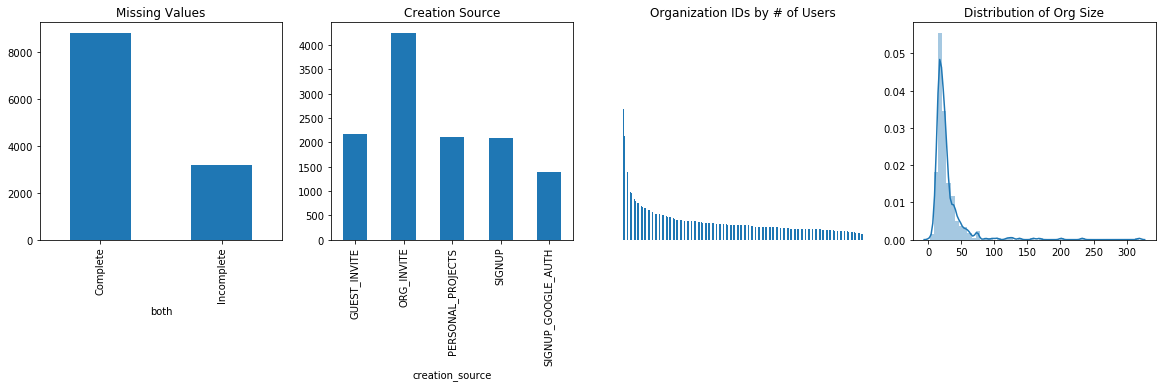

In [5]:
users = raw_users 
users.ix[ raw_users.object_id.isin(raw_user_engagement.user_id),"both"] = "Complete"
users.ix[~raw_users.object_id.isin(raw_user_engagement.user_id),"both"] = "Incomplete"

plt.figure(figsize = (20,4))

plt.subplot(1,4,1)
users.groupby('both').size().plot.bar()
plt.title('Missing Values')

plt.subplot(1,4,2)
raw_users.groupby('creation_source').size().plot.bar()
plt.title('Creation Source') 

plt.subplot(1,4,3)
orgs = raw_users.groupby('org_id').size()
orgs.reset_index(drop = True).sort_values(ascending = False).plot.bar(title = 'Organization IDs by # of Users')
plt.axis('off')

plt.subplot(1,4,4)
sns.distplot(orgs.dropna())
plt.title('Distribution of Org Size')

plt.show()

## 3.  ETL to create Target

In [6]:
user_engagement = raw_user_engagement
user_engagement.time_stamp = pd.to_datetime(user_engagement.time_stamp)
user_engagement = user_engagement.set_index('time_stamp').to_period('d')
user_engagement = user_engagement.groupby('user_id')[['visited']]
user_engagement = user_engagement.resample("1d").count().rolling(window=7, min_periods=1).sum()
user_engagement['meets'] = (user_engagement.visited > 2)+0
def target(x):
    return (sum(x) > 0) + 0
target = user_engagement.reset_index().pivot_table(index = 'user_id', values = 'meets', aggfunc = [target])

#### Plot Target Classes

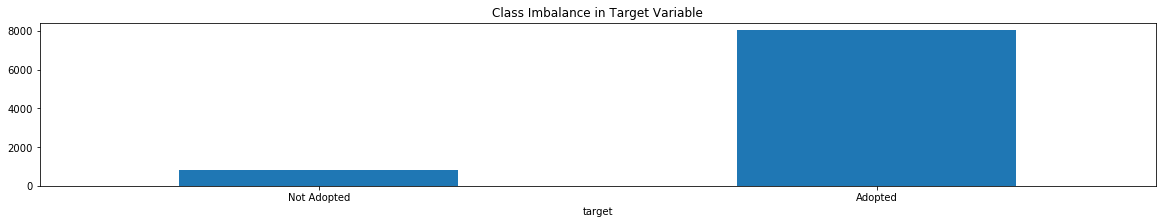

In [7]:
plt.figure(figsize = (20,3))
plt.title('')
target.groupby('target').size().plot.bar()
plt.xticks([0,1],('Not Adopted','Adopted'), rotation = 0)
plt.title('Class Imbalance in Target Variable')
plt.show()

## 4. Data Cleanse  + Feature Engineering:

In [8]:
# Read data
raw_users = pd.read_csv('./users.csv', encoding='latin-1')

# Create Email Cleaner
def email_cleaner(x):
    return x[x.find("@"):].replace("@","").replace(".com", "").replace(".de","")

# Create X and Y frames
users = raw_users
X = users
y = users.merge(target, left_on = 'object_id', right_index=True, how = 'left').fillna(0).target

# Clean Nulls in invited user. Make binary.
X.ix[X.invited_by_user_id.isnull(),'invited_by_user_id'] = 0
X.ix[X.invited_by_user_id != 0,'invited_by_user_id'] = 1

# Clean Emails to show domain only
X.email = X.email.apply(email_cleaner)
most_popular_emails = X.groupby('email').size().sort_values(ascending = False).head(6).index
X.ix[~X.email.isin(most_popular_emails),'email'] = 'uncommon'
X['email'] = "email_"+X.email

# Clean ORG ID Column
X.org_id = "org_"+ X.org_id.astype(str)

# Create "recent_login_less_created": 
# which looks at the number of days between create date and account creation

X.creation_time = pd.to_datetime(X.creation_time)
X.last_session_creation_time = [i if pd.isnull(i) == True else datetime.fromtimestamp(int(i)).strftime('%Y-%m-%d %H:%M:%S') for i in X.last_session_creation_time]
X.ix[X.last_session_creation_time.isnull(),['last_session_creation_time']] = X.ix[X.last_session_creation_time.isnull(),].creation_time.astype('O')
X.last_session_creation_time = pd.to_datetime(X.last_session_creation_time)
X['recent_login_less_created'] = (X.last_session_creation_time.dt.date - X.creation_time.dt.date)
X['recent_login_less_created'] = (X.recent_login_less_created / np.timedelta64(1, 'D')).astype(int)
X['recent_login_less_created'] = [0 if i<0 else i for i in X['recent_login_less_created']]

# Create week day
creation_weekday = pd.to_datetime(X["creation_time"]).dt.weekday_name
creation_month = pd.to_datetime(X["creation_time"]).dt.month
creation_time = pd.to_datetime(X["creation_time"]).dt.hour

# Generate Dummy columns
month_dummy = pd.get_dummies(creation_month)
weekday_dummy = pd.get_dummies(creation_weekday)
org_dummy = pd.get_dummies(X.org_id)
email_dummy = pd.get_dummies(X.email)
source_dummy = pd.get_dummies(X.creation_source)

# Append Dummy Columns to "X" Frame.
X = pd.concat(
    [X,
     creation_time,
     #org_dummy,
     month_dummy,
     weekday_dummy,
     source_dummy,
     email_dummy], axis = 1)

# Remove Non-Features
X = X.drop(['email','name','creation_time','last_session_creation_time','object_id','org_id','creation_source'], axis = 1)

## 5. Split Data, Hypertune, Cross Validation
- Parameter tuning
- Random Search
- Cross validation scores with 5 folds cross validation

In [9]:
#  Progress Bar Print Out
def f1_prog_bar(*args):
    score = f1_scorer(*args)
    print('F1 is {}'.format(score))
    return score

# 15/85 Train Test Split. 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100, test_size = .15)
X_train.shape,y_train.shape, X_test.shape, y_test.shape,

# Parameter Grid
param_dist = {
    'criterion': ['gini', 'entropy'],
    "max_depth": np.arange(5,30),
    "max_features": np.arange(2,X.shape[1]),
    "n_estimators": np.arange(300,1000)}

# Instantiate RF model with class weights bc of class imbalance
clf = RandomForestClassifier(n_jobs=-1, random_state = 123, class_weight = 'balanced')

# run randomized search with 30 iterations
# 5 fold cross validation
# score on "f1"

n_iter_search = 20

random = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    cv=5,
    n_iter=n_iter_search, 
    scoring = 'f1' #f1_prog_bar
)
random.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29]), 'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]), 'n_estimators': array([300, 301, ..., 998, 999])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          ret

### 6. Test Performance on holdout data

In [10]:
# Fit on Train, test on 
random.best_estimator_.fit(X_train.values, y_train.values)
y_pred_in = random.best_estimator_.predict(X_test)
y_test_in = y_test
print(classification_report(y_pred=y_pred_in, y_true=y_test_in))
print(confusion_matrix(y_pred=y_pred_in, y_true=y_test_in))

             precision    recall  f1-score   support

        0.0       0.62      0.66      0.64       595
        1.0       0.83      0.80      0.81      1205

avg / total       0.76      0.75      0.76      1800

[[393 202]
 [240 965]]


### 7. Feature Importance

** Method 1: Via Random Forest Model** 

In [11]:
importance_m1 = pd.DataFrame(
    {'Variable':X_test.columns.values,
     'Importance_RF':random.best_estimator_.feature_importances_},
    columns = ["Variable", "Importance_RF"])\
    .sort_values('Importance_RF', ascending = False)
    
this = MinMaxScaler()
importance_m1.Importance_RF = this.fit_transform(importance_m1.Importance_RF)

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


** Method 2: Permutation Feature Importance**

In [13]:
frame_in = X_test
clf = random.best_estimator_
clf.fit(X_train, y_train)
baseline = clf.score(X_test, y_test)
baseline

def shuffler_col(col,frame_in ):   
    ## create new frame 
    frame_i = pd.concat(
        [frame_in[col].sample(frac = 1).reset_index(drop = True), # shuffle a column, reset index
         frame_in.drop(col, 1).reset_index(drop = True)],1) # drop column shuffled, reset index
    
    frame_i = frame_i[frame_in.columns] # reorder to original
    return frame_i

frame_in = frame_in
shuffles = 100
measure = [] # will hold all variables

for i in frame_in:
    col_i =[] # hold all shuffles of column i
    for j in range(shuffles):
            col_i_shuffled = shuffler_col(col = i , frame_in = frame_in)
            col_i.append(clf.score(col_i_shuffled, y_test)<baseline) # score and tell me if it's < baseline (it does worse)
     # append the mean, aka - the proportion of times where shuffled data set of a particular column i < baseline score
    measure.append(np.mean(col_i))


In [54]:
importance_m2 = pd.DataFrame(
    list(
        zip(
            X_test.columns.values,measure)), 
    columns = ['Variable','Importance_Permute'])\
    .sort_values('Importance_Permute', ascending = False)
    
this = MinMaxScaler()
importance_m2.Importance_Permute = this.fit_transform(importance_m2.Importance_Permute)

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [55]:
importance1 = importance_m1.sort()
importance2 = importance_m2.sort()
importance1['number'] = np.arange(0,importance1.shape[0]).astype("O")
importance1.Importance_RF = importance1.Importance_RF.rank(ascending = False)
importance1['Importance_Permute'] = importance2.Importance_Permute.rank(ascending = False)
importance1.Variable = importance1['number'].map(str)+". "+importance1['Variable'].map(str)

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':
C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  from ipykernel import kernelapp as app


In [56]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.25, point['y']+.25, str(point['val']))


The plot below compares two methods of feature importance. On the Y-axis, we have feature importance from a random forest model. Alternatively, on the X-axis we have feature importance produced using a shuffling method to uncover a variable's impact on prediction outcomes versus a baseline. The result is two variables that are ranked according to these methods.

Lower left quadrant highlights variables that move methods determine as most important. 

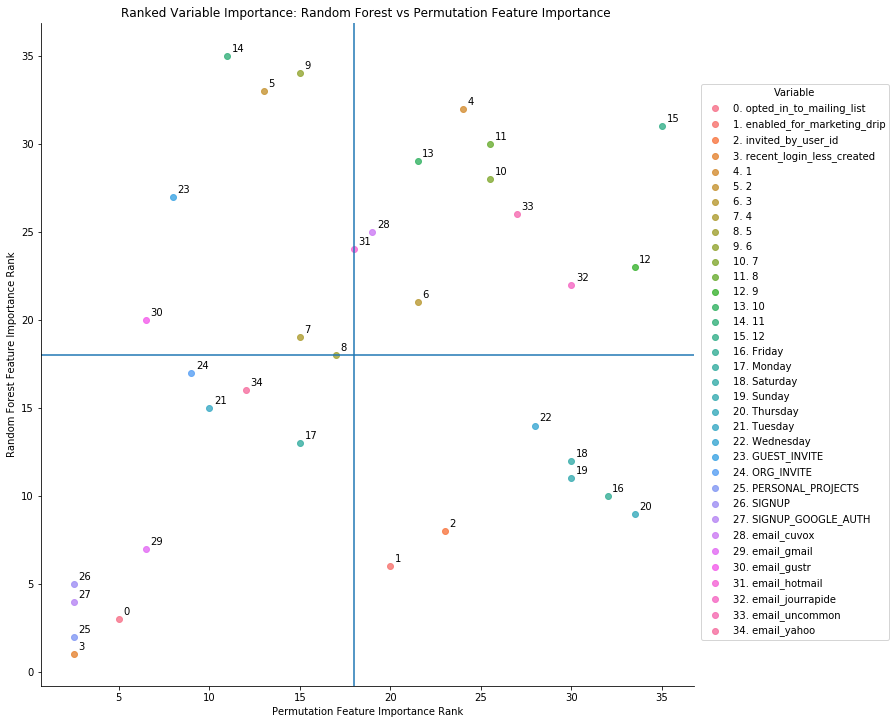

In [59]:
sns.lmplot(x = 'Importance_Permute', y = 'Importance_RF',
           data = importance1, hue = 'Variable',  fit_reg= False, size=10, aspect=1)
label_point(
    x = importance1.Importance_Permute, y = importance1.Importance_RF, val = importance1.number, ax = plt.gca())  
plt.axvline(x = np.median(importance1.Importance_Permute))
plt.axhline(y = np.median(importance1.Importance_RF))
plt.title("Ranked Variable Importance: Random Forest vs Permutation Feature Importance ")
plt.xlabel('Permutation Feature Importance Rank')
plt.ylabel('Random Forest Feature Importance Rank')
plt.show()

### 8. Final Thoughts

Both methods suggest the following are large drivers:
0. Opted for a mailing list
3. Time between Recent Login and first sign up
25. Having a personal project
26. Signing up Traditionally
27. Signed up via Google authentication
29. An email being "GMail"


Both methods suggest that 3. Length of time between first and most recent log in is a high driver of adoption. 